In [291]:
import pandas as pd
import xarray as xr
import numpy as np 

## Reading the Data

In [43]:
# Opening the data as xarray datasets
ds_o = xr.open_dataset('observation.nc')
ds_f = xr.open_dataset('forecast.nc')

# Converting them to Pandas dataframes
df_observation = ds_o.to_dataframe().reset_index()
df_forecast = ds_f.to_dataframe().reset_index()

## Data Transformation
Here we perform just some simple transformations to organize the data and have the temperatures in the same unities.

In [162]:
# Converting forecast temperature from Kelvin to Celsius so we can work with the same unities
df_forecast['temperature_f'] = df_forecast['t2m'] -273.15
df_observation.rename(columns={'temperatura': 'temperature_o'}, inplace=True)

## RMSE Index

The RMSE is used to evaluate the model performance for our forecast. We calculate it first for all hours, latitudes and longitudes in the DataFrame with the predicted value as the forecasted temperature and the observed value as the observed temperature using the formula below. This index is calculated in Celsius.

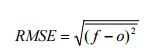

In [278]:
# We concat data from the forecast and observation dataframes to calculate RMSE index
df_joined = pd.concat([df_forecast[['time', 'lat', 'lon', 'temperature_f']], 
                        df_observation[['temperature_o']]], axis=1)
df_joined.set_index('time', inplace=True)
df_joined.head()

,lat,lon,temperature_f,temperature_o
time,,,,
2018-04-14 00:00:00,-25.294006,-52.993698,24.727020,24.555346
2018-04-14 01:00:00,-25.294006,-52.993698,24.315643,23.840425
2018-04-14 02:00:00,-25.294006,-52.993698,23.835083,24.558758
2018-04-14 03:00:00,-25.294006,-52.993698,23.397949,25.346521
2018-04-14 04:00:00,-25.294006,-52.993698,23.013519,25.399191


In [269]:
# Create a function to calculate RMSE (forecasted temperature vs. observed temperature) 
# for each point in the DataFrame
def rmse(df, predicted, observed):
    pred = df[predicted]
    obs = df[observed]
    df['rmse'] = np.sqrt(((pred - obs)**2))
    df_rmse = df[['lat', 'lon', 'rmse']].copy()
    return df_rmse

In [271]:
df_rsme = rmse(df_joined, 'temperature_f', 'temperature_o')

In [279]:
# Calculate the mean RMSE for every period of 6h
df_rmse_6h = df_rmse.groupby([df_results['lon'], df_results['lat'], pd.Grouper(freq='6h')]).mean()

## Storing RMSE Data

In [284]:
# Converting the DataFrame with results back to xarray format
rmse_results_ds = df_rmse_6h.to_xarray()
rmse_results_ds

<xarray.Dataset>
Dimensions:  (lon: 37, lat: 25, time: 12)
Coordinates:
    lon      (lon, lat, time) float32 -52.99 -52.99 -52.99 ... -44.25 -44.25
    lat      (lon, lat, time) float32 -25.29 -25.29 -25.29 ... -19.92 -19.92
  * time     (time) datetime64[ns] 2018-04-14 ... 2018-04-16T18:00:00
Data variables:
    rmse     (lon, lat, time) float32 1.379 3.37 1.118 ... 2.61 4.875 1.659

In [285]:
# Convert to nc file and store it in rmse_results.nc
rmse_results_ds.to_netcdf(path='rmse_results.nc', mode='w', format="NETCDF4_CLASSIC")

## RMSE Results for São Paulo
We query only the data for São Paulo using the given coordinates (latitude: -23.524933, longitude: -46.6783, as stored in the forecast.nc file) and create a DataFrame to store this particular data. We also take the mean RMSE for each period of 6h.

In [294]:
df_sp = df_rmse.copy().query('lat == -23.524933 and lon == -46.6783')

In [288]:
# Grouping the São Paulo data and taking the mean RMSE for each period of 6h
df_sp_6h = df_sp.groupby([df_sp['lon'], df_sp['lat'], pd.Grouper(freq='6h')]).mean()
df_sp_6h.reset_index(inplace=True)

## Visualization
Finally, we plot the data to visualize the RSME variation through time (for the time series and for each period of 6h).

In [323]:
import seaborn as sns 
import matplotlib.pyplot as plt  
import matplotlib.dates as md

sns.set_theme()

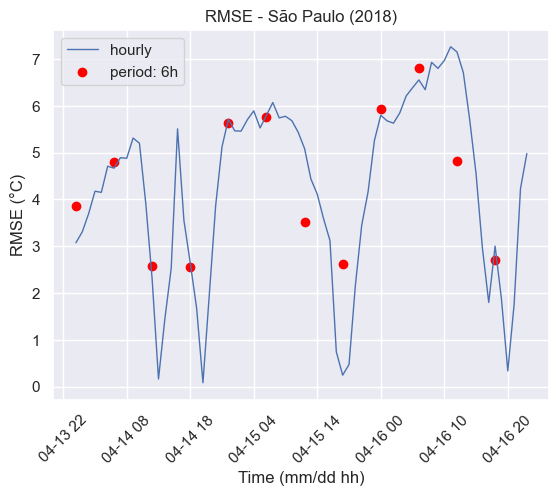

In [362]:
fig, ax1 = plt.subplots()

ax1.plot(df_sp.index, df_sp['rmse'], linewidth=1)
ax1.scatter(df_sp_6h['time'], df_sp_6h['rmse'], linewidth=1, color='red')
ax1.set_xticks(df_sp.index)
ax1.xaxis.set_major_locator(md.HourLocator(interval = 10))
_ = plt.xticks(rotation=45) 
plt.xlabel('Time (mm/dd hh)')
plt.ylabel('RMSE (°C)')
plt.title('RMSE - São Paulo (2018)')
plt.legend(['hourly', 'period: 6h'])
plt.show()

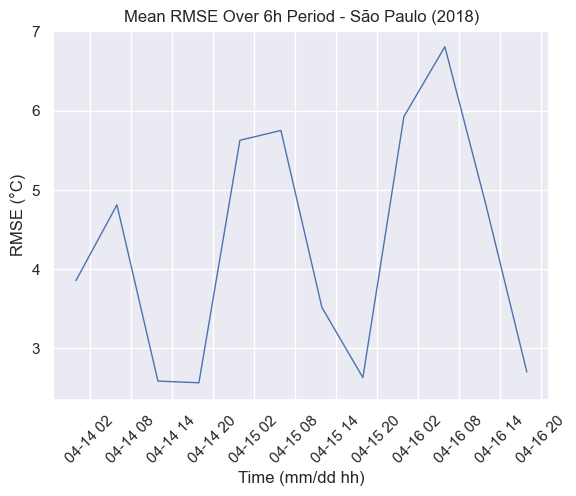

In [368]:
fig, ax2 = plt.subplots()

ax2.plot(df_sp_6h['time'], df_sp_6h['rmse'], linewidth=1)
ax2.set_xticks(df_sp_6h['time'])
ax2.xaxis.set_major_locator(md.HourLocator(interval = 6))
_ = plt.xticks(rotation=45) 
plt.xlabel('Time (mm/dd hh)')
plt.ylabel('RMSE (°C)')
plt.title('Mean RMSE Over 6h Period - São Paulo (2018)')
plt.show()